In [2]:
import torch
from torch import Tensor
import numpy as np

import matplotlib.pyplot as plt

$$
(n+1) P_{n+1}(x) = (2n + 1) x P_n (x) - n P_{n-1}(x)
$$

donde
$$
P_0(x) = 1, P_1(x) = x
$$

In [3]:
# genera polinomios de legendre usando recurrencia
def Pl(n, x):
    if n == 0:
        return 0*x + 1 # esto hace que devuelva un tensor
    elif n == 1:
        return x
    else:
        n = n - 1 # ya la formula esta en P(n+1,x)
        p1 = (2*n + 1) * x * Pl(n, x)
        p2 = n * Pl(n-1,x)
        return (p1 - p2 )/(n+1)

In [4]:
# el espacio de grafico
x = torch.Tensor([i for i in range(10)])
x.requires_grad_()

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], requires_grad=True)

In [5]:
N = 50
x = torch.linspace(-1,1,N)
x.requires_grad_()

tensor([-1.0000, -0.9592, -0.9184, -0.8776, -0.8367, -0.7959, -0.7551, -0.7143,
        -0.6735, -0.6327, -0.5918, -0.5510, -0.5102, -0.4694, -0.4286, -0.3878,
        -0.3469, -0.3061, -0.2653, -0.2245, -0.1837, -0.1429, -0.1020, -0.0612,
        -0.0204,  0.0204,  0.0612,  0.1020,  0.1429,  0.1837,  0.2245,  0.2653,
         0.3061,  0.3469,  0.3878,  0.4286,  0.4694,  0.5102,  0.5510,  0.5918,
         0.6327,  0.6735,  0.7143,  0.7551,  0.7959,  0.8367,  0.8776,  0.9184,
         0.9592,  1.0000], requires_grad=True)

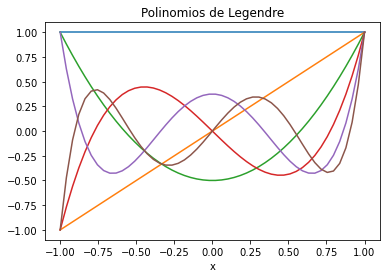

In [6]:
xs = x.detach()
for l in range(0,5+1):
    plt.plot(xs, Pl(l,xs))

plt.title('Polinomios de Legendre')
plt.xlabel('x')
plt.show()

Ahora queremos que se comporte similar a los polinomios de Legendre de otras librerias

In [7]:
from numpy.polynomial.legendre import Legendre

queremos proveer de los metodos:

The Legendre class provides the standard Python numerical methods
'+', '-', '*', '//', '%', 'divmod', '**', and '()' 

In [8]:
coef = Tensor([1,2,3])
coef.requires_grad_()

result = 0
for idx,C in enumerate(coef):
    result += C * Pl(idx, x)

result

tensor([ 2.0000,  1.7218,  1.4586,  1.2103,  0.9771,  0.7589,  0.5556,  0.3673,
         0.1941,  0.0358, -0.1075, -0.2357, -0.3490, -0.4473, -0.5306, -0.5989,
        -0.6522, -0.6905, -0.7139, -0.7222, -0.7155, -0.6939, -0.6572, -0.6056,
        -0.5389, -0.4573, -0.3607, -0.2491, -0.1224,  0.0192,  0.1758,  0.3474,
         0.5339,  0.7355,  0.9521,  1.1837,  1.4302,  1.6918,  1.9683,  2.2599,
         2.5664,  2.8880,  3.2245,  3.5760,  3.9425,  4.3240,  4.7205,  5.1320,
         5.5585,  6.0000], grad_fn=<AddBackward0>)

Y la derivada
$$
\frac{d}{dx} P_n(x) = \frac{n}{x^2 - 1} (x P_n - P_{n-1})
$$

In [9]:
# genera derivadas polinomios de legendre usando recurrencia
def dxPl(n, x):
    if n == 0:
        return 0*x + 0
    elif n == 1:
        return 0*x + 1
    else:
        n = n-1 # la regla es para n+1
        return (n+1)* Pl(n,x) + x * dxPl(n,x)


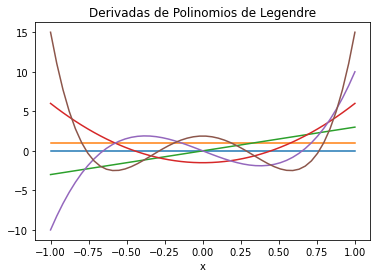

In [10]:
xs = x.detach()
for l in range(0,5+1):
    plt.plot(xs, dxPl(l,xs))
plt.title('Derivadas de Polinomios de Legendre')
plt.xlabel('x')
plt.show()

aqui una implementación para crear el grafo de autoderivación implementando lo que sabemos de los polinomios de legendre

In [35]:
import torch
from torch.autograd import Function, Variable

# Funciones auxiliares para los polinomios de Legendre
def Pl(n, x):
    if n == 0:
        return 0 * x + 1
    elif n == 1:
        return x
    else:
        n = n - 1
        p1 = (2 * n + 1) * x * Pl(n, x)
        p2 = n * Pl(n - 1, x)
        return (p1 - p2) / (n + 1)

def dxPl(n, x):
    if n == 0:
        return 0 * x + 0
    elif n == 1:
        return 0 * x + 1
    else:
        n = n - 1
        return (n + 1) * Pl(n, x) + x * dxPl(n, x)

class PLegendre(Function):
    
    @staticmethod
    def forward(ctx, n, input):
        ctx.save_for_backward(input)
        ctx.n = n
        output = Pl(n, input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        n = ctx.n
        grad_output_var = torch.autograd.Variable(grad_output, requires_grad=False)
        input_var = torch.autograd.Variable(input, requires_grad=True)
        dxpl = dxPl(n, input_var)
        return None, grad_output_var * dxpl


In [49]:
n = torch.tensor([2], dtype=torch.float64, requires_grad=True)
x = torch.tensor([-1,0,1], dtype=torch.float64, requires_grad=True)

output = PLegendre.apply(n, x)
output.backward(torch.ones_like(output))

grad_n = n.grad
grad_x = x.grad


print("grad_n:", grad_n)
print("grad_x:", grad_x)


grad_n: None
grad_x: tensor([-3.,  0.,  3.], dtype=torch.float64)


como se observa, la manera correcta de utilizar es
```python
P2 = PLegendre.apply
P2(n,x)
```

Pues entonces guarda el grafo computacional correcto

In [ ]:
import math

dtype = torch.float
device = torch.device("cpu")

x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

In [ ]:
# que polinomio de legendre usar
n = 3

learning_rate = 5e-6
for t in range(2000):
    # To apply our Function, we use Function.apply method. We alias this as 'P3'.
    P3 = torchPl

    # Forward pass: compute predicted y using operations; we compute
    # P3 using our custom autograd operation.
    y_pred = a + b * P3(n,c + d * x)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

In [60]:
class LegendrePolynomial():
    """ Generate a sum of legendre polynomials that work with torch grad"""
    def __init__(self, coef, domain=None):
        self.coef = coef
        self.domain = domain

    def __call__(self, x):
        result = 0
        for idx,C in enumerate(self.coef):
            result += C * PLegendre.apply(idx, x)
        return result

        

In [61]:
coefx = torch.tensor([np.random.randint(10) for i in range(9)],dtype=torch.float64, requires_grad=True)
coefy = torch.tensor([np.random.randint(10) for i in range(5+i)],dtype=torch.float64,requires_grad=True)
fx = LegendrePolynomial(coefx)
fy = PLegendre(coefy, domain=[yL,yR])


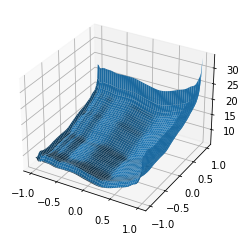

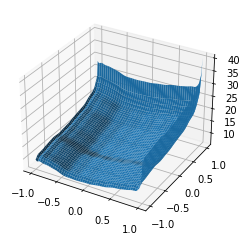

In [68]:
xL,xR = -1,1
yL, yR = -1,1


import matplotlib.pyplot as plt
xs = torch.linspace(xL, xR, steps=100)
ys = torch.linspace(yL, yR, steps=100)
x, y = torch.meshgrid(xs, ys, indexing='xy')

for i in range(9):
    coefx = torch.tensor([np.random.randint(10)/i for i in range(1,25)],dtype=torch.float64, requires_grad=True)
    coefy = torch.tensor([np.random.randint(10)/i for i in range(1,25)],dtype=torch.float64,requires_grad=True)
    fx = LegendrePolynomial(coefx)
    fy = LegendrePolynomial(coefy, domain=[yL,yR])
    z = fx(x) + fy(y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x.detach(), y.detach(), z.detach())
    plt.show()

Testing